In [1]:
import pandas as pd
import numpy as np
import gensim
import matplotlib.pyplot as plt
import re
from pymystem3 import Mystem
import smart_open
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import *
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv('data/contracts.csv',sep=';', header=None, names=['contract','service_id','service_name','user_request'])

In [3]:
data.head()

,contract,service_id,service_name,user_request
0,354,4,Сантехник,лалсо
1,364,16,Сборка и ремонт мебели,заказ для Александра Трушкина
2,370,13,Ремонт компьютеров,заказ для Алишера
3,379,14,Муж на час,для Ерлана
4,385,14,Муж на час,мастер мастеров


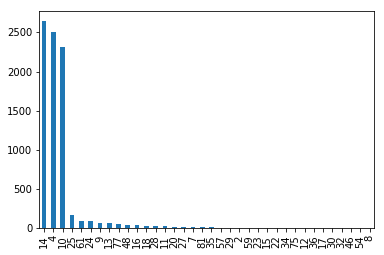

In [4]:
data.service_id.value_counts().plot(kind='bar')

In [5]:
data4 = data[~data.service_id.isin([14,10,4])].copy()
data4.head()

,contract,service_id,service_name,user_request
1,364,16,Сборка и ремонт мебели,заказ для Александра Трушкина
2,370,13,Ремонт компьютеров,заказ для Алишера
9,550,13,Ремонт компьютеров,где фото?
11,568,13,Ремонт компьютеров,видно имя?
13,573,13,Ремонт компьютеров,рейтинг нулевой


In [6]:
data.loc[~data.service_id.isin([14,10,4]), 'service_id'] = 0

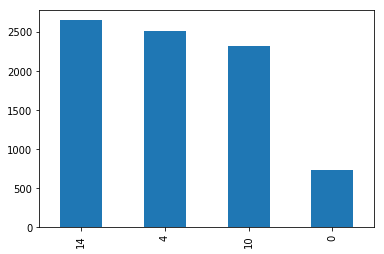

In [7]:
data.service_id.value_counts().plot(kind='bar')

In [8]:
vc = data4.service_id.value_counts().sort_values(ascending=False)[5:].index.tolist()
ind = data4[data4['service_id'].isin(vc)].index
data4.drop(ind, inplace=True)

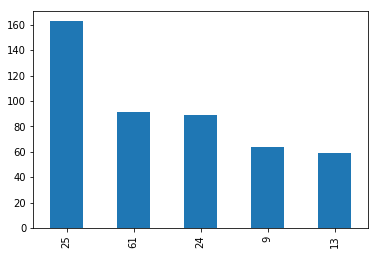

In [9]:
data4.service_id.value_counts().plot(kind='bar')

In [10]:

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^а-я ]')

In [11]:
def remove_stopwords(text: str) -> str:
        try:
            text = text.lower()
            text = REPLACE_BY_SPACE_RE.sub(' ', text)
            text = BAD_SYMBOLS_RE.sub('', text)
            return " ".join([token for token in text.split() if token not in mystopwords])
        except:
            return ""
        
def lemmatize(text: str) -> str:
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

def remove_stoplemmas(text: str) -> str:
    try:
        return " ".join([token for token in text.split() if token not in mystoplemmas])
    except:
        return ""

def clear_text(text: str) ->str:
    cText = remove_stopwords(text)
    cText = lemmatize(cText)
    cText = remove_stoplemmas(cText)
    return cText

In [12]:
m = Mystem()

In [14]:
import nltk
nltk.download('stopwords')
mystopwords = stopwords.words('russian') + ['это', 'наш', 'тыс', 'млн', 'млрд', 'также',  'т', 'д','iKomek.kz','кв']
mystoplemmas = ['который', 'прошлый', 'сей', 'свой', 'наш', 'мочь']

[nltk_data] Downloading package stopwords to /home/mic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
data['lemmas'] = data.user_request.apply(lambda x: clear_text(x))

In [24]:
data.head()

,contract,service_id,service_name,user_request,lemmas
0,354,4,Сантехник,лалсо,лалсо
1,364,0,Сборка и ремонт мебели,заказ для Александра Трушкина,заказ александр трушкин
2,370,0,Ремонт компьютеров,заказ для Алишера,заказ алишер
3,379,14,Муж на час,для Ерлана,ерлан
4,385,14,Муж на час,мастер мастеров,мастер мастер


In [39]:
vec_model = TfidfVectorizer(analyzer='char', ngram_range={4,6})

In [40]:
X = data.lemmas
Y = data.service_id

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [90]:
def print_result(model, text, x_test, y_true, cv, proba=True):
    print('Predicted service ID: ', model.predict([text]))
    if proba:
        pred_service = model.predict_proba([text])
        print('Predic_proba : ', pred_service)
    predictions = model.predict(x_test)
    print("Precision: {0:6.2f}".format(precision_score(y_true, predictions, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(y_true, predictions, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(y_true, predictions, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(y_true, predictions)))
    print(classification_report(y_true, predictions))
    labels = ['Другие','Сантехник','Электрик','Муж на час']
    sns.heatmap(data=confusion_matrix(y_true, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion matrix")
    plt.show()

In [42]:
param = [
         {"C":[5,10,50], 'penalty': ['l1'], 'solver': ['liblinear', 'saga']},
         {"C":[5,10,50],'penalty': ['l2'], 'solver': ['newton-cg'] }
        ]
model = LogisticRegression(multi_class = 'auto', max_iter = 200)

In [45]:
cv = GridSearchCV(model, param, cv = 10)
logreg = Pipeline([
                    ('tfidf', vec_model),
                    ('clf', cv),
               ])
logreg.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ", cv.best_params_)
print("accuracy :", cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 5, 'penalty': 'l2', 'solver': 'newton-cg'}
accuracy : 0.77535044602221


In [46]:
test_score = logreg.score(X_test, y_test)
print('Test score: ', test_score)

Test score:  0.7719881744271988


In [47]:
test_text = 'генеральная уборка 4-х комнатной квартиры'

array([0])

Predicted service ID:  [0]
Predic_proba :  [[0.52766356 0.15625559 0.10216178 0.21391908]]
Precision:   0.75
Recall:   0.59
F1-measure:   0.61
Accuracy:   0.66
              precision    recall  f1-score   support

           0       0.97      0.23      0.37       251
           4       0.74      0.72      0.73       828
          10       0.75      0.76      0.75       735
          14       0.52      0.65      0.58       892

   micro avg       0.66      0.66      0.66      2706
   macro avg       0.75      0.59      0.61      2706
weighted avg       0.69      0.66      0.65      2706



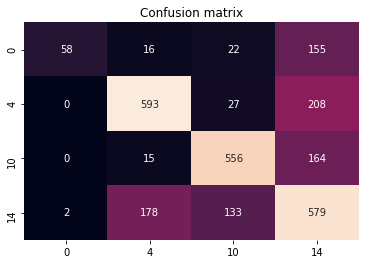

In [56]:
print_result(logreg, test_text, X_test, y_test, cv)

In [53]:
param = {"n_estimators":[5,10,50], 'max_depth': [5,10,20]}      
model = RandomForestClassifier(min_samples_leaf=20, max_features=0.5)
cv = GridSearchCV(model, param, cv = 3, n_jobs = 7)
rf = Pipeline([
                    ('tfidf', vec_model),
                    ('clf', cv),
               ])
rf.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ", cv.best_params_)
print("accuracy :", cv.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 20, 'n_estimators': 50}
accuracy : 0.6602949208083014


Predicted service ID:  [0]
Predic_proba :  [[0.52766356 0.15625559 0.10216178 0.21391908]]
Precision:   0.75
Recall:   0.59
F1-measure:   0.61
Accuracy:   0.66
              precision    recall  f1-score   support

           0       0.97      0.23      0.37       251
           4       0.74      0.72      0.73       828
          10       0.75      0.76      0.75       735
          14       0.52      0.65      0.58       892

   micro avg       0.66      0.66      0.66      2706
   macro avg       0.75      0.59      0.61      2706
weighted avg       0.69      0.66      0.65      2706



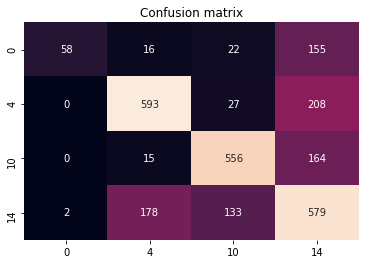

In [57]:
print_result(logreg, test_text, X_test, y_test, cv)

In [63]:
param = [
    {"loss":['hinge','squared_hinge'], 'penalty': ['l2']},
]
model = LinearSVC()
cv = GridSearchCV(model, param, cv = 3, n_jobs = 7)
svc = Pipeline([
                    ('tfidf', vec_model),
                    ('clf', cv),
               ])
svc.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ", cv.best_params_)
print("accuracy :", cv.best_score_)

tuned hpyerparameters :(best parameters)  {'loss': 'hinge', 'penalty': 'l2'}
accuracy : 0.7748042963772074


Predicted service ID:  [0]
Precision:   0.75
Recall:   0.59
F1-measure:   0.61
Accuracy:   0.66
              precision    recall  f1-score   support

           0       0.97      0.23      0.37       251
           4       0.74      0.72      0.73       828
          10       0.75      0.76      0.75       735
          14       0.52      0.65      0.58       892

   micro avg       0.66      0.66      0.66      2706
   macro avg       0.75      0.59      0.61      2706
weighted avg       0.69      0.66      0.65      2706



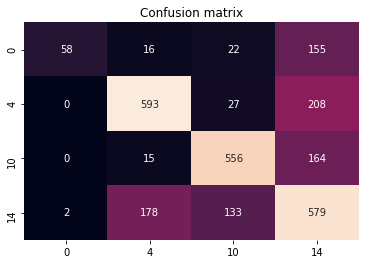

In [66]:
print_result(svc, test_text, X_test, y_test, cv, False)

In [72]:
param = [
    {'alpha': [0.1, 1.0], 'fit_prior':[True, False]},
]
model = MultinomialNB()
cv = GridSearchCV(model, param, cv = 3, n_jobs = 7)
nb = Pipeline([
                    ('tfidf', vec_model),
                    ('clf', cv),
               ])
nb.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ", cv.best_params_)
print("accuracy :", cv.best_score_)

tuned hpyerparameters :(best parameters)  {'alpha': 1.0, 'fit_prior': False}
accuracy : 0.7596941561987984


Predicted service ID:  [0]
Predic_proba :  [[0.74054425 0.01140127 0.08196786 0.16608662]]
Precision:   0.75
Recall:   0.59
F1-measure:   0.61
Accuracy:   0.66
              precision    recall  f1-score   support

           0       0.97      0.23      0.37       251
           4       0.74      0.72      0.73       828
          10       0.75      0.76      0.75       735
          14       0.52      0.65      0.58       892

   micro avg       0.66      0.66      0.66      2706
   macro avg       0.75      0.59      0.61      2706
weighted avg       0.69      0.66      0.65      2706



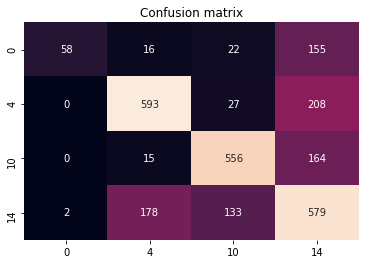

In [74]:
print_result(nb, test_text, X_test, y_test, cv, True)

In [75]:
from sklearn.neighbors import KNeighborsClassifier

In [81]:
param = [
    {'n_neighbors': [50,100, 150]},
]
model = KNeighborsClassifier()
cv = GridSearchCV(model, param, cv = 3)
kn = Pipeline([
                    ('tfidf', vec_model),
                    ('clf', cv),
               ])
kn.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ", cv.best_params_)
print("accuracy :", cv.best_score_)

tuned hpyerparameters :(best parameters)  {'n_neighbors': 100}
accuracy : 0.6934279992718004


Predicted service ID:  [0]
Predic_proba :  [[0.34 0.25 0.23 0.18]]
Precision:   0.75
Recall:   0.59
F1-measure:   0.61
Accuracy:   0.66
              precision    recall  f1-score   support

           0       0.97      0.23      0.37       251
           4       0.74      0.72      0.73       828
          10       0.75      0.76      0.75       735
          14       0.52      0.65      0.58       892

   micro avg       0.66      0.66      0.66      2706
   macro avg       0.75      0.59      0.61      2706
weighted avg       0.69      0.66      0.65      2706



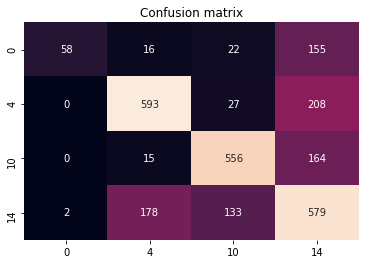

In [88]:
print_result(kn, test_text, X_test, y_test, cv, True)

In [84]:
from mlxtend.classifier import StackingClassifier

In [92]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(max_depth = 20, n_estimators = 50, random_state=1)
clf3 = LinearSVC(loss = 'hinge', penalty = 'l2',max_iter=2000)
lr = LogisticRegression(multi_class = 'auto', penalty = 'l2', solver = 'newton-cg')
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)
params = {'meta_classifier__C': [0.1, 5, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
stack = Pipeline([
                    ('tfidf', vec_model),
                    ('clf', grid),
               ])
stack.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ", grid.best_params_)
print("accuracy :", grid.best_score_)

/var/www/pvm/jupiter/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/var/www/pvm/jupiter/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/var/www/pvm/jupiter/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/var/www/pvm/jupiter/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/var/www/pvm/jupiter/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
 

tuned hpyerparameters :(best parameters)  {'meta_classifier__C': 0.1}
accuracy : 0.585654469324595


Predicted service ID:  [0]
Predic_proba :  [[9.49958137e-01 4.98026447e-02 2.39217876e-04 8.86212713e-10]]
Precision:   0.63
Recall:   0.58
F1-measure:   0.59
Accuracy:   0.58
              precision    recall  f1-score   support

           0       0.80      0.60      0.68       251
           4       0.56      0.81      0.66       828
          10       0.50      0.56      0.53       735
          14       0.66      0.37      0.47       892

   micro avg       0.58      0.58      0.58      2706
   macro avg       0.63      0.58      0.59      2706
weighted avg       0.60      0.58      0.57      2706



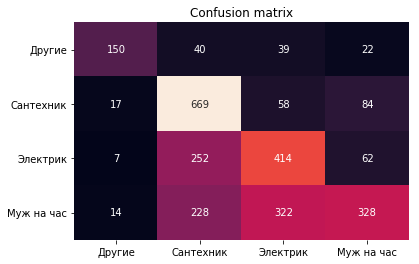

In [93]:
print_result(stack, test_text, X_test, y_test, grid, True)